In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Paths (persisted to Drive as JSON so future cells can reload)
import os, json, subprocess
from pathlib import Path

GDRIVE   = Path('/content/drive/MyDrive/USFM')
ENV_DIR  = GDRIVE / 'usfm_env'
WHEELS   = ENV_DIR / 'wheels'
USFM_DIR = GDRIVE / 'USFM_repo'             # USFM repo lives here
DATA_DIR = GDRIVE / 'USFM_datasets'    # your prepared datasets (Seg/, Cls/)
ASSETS   = ENV_DIR / 'assets' / 'FMweight'  # put USFM_latest.pth here
MMSEG_DIR= ENV_DIR / 'mmsegmentation'  # modified mmseg fork/branch

for p in [ENV_DIR, WHEELS, DATA_DIR, ASSETS, USFM_DIR]:
    p.mkdir(parents=True, exist_ok=True)

def run(cmd, cwd=None):
    print('>>', cmd)
    subprocess.run(cmd, shell=True, check=True, cwd=str(cwd) if cwd else None)



In [3]:
# Clone/update USFM
if not (USFM_DIR / '.git').exists():
    run(f'git clone https://github.com/openmedlab/USFM.git "{USFM_DIR}"')
else:
    run('git pull --ff-only', cwd=USFM_DIR)

# Clone/update modified mmseg fork (branch: gj_mmcv2_2_0)
if not (MMSEG_DIR / '.git').exists():
    run(f'git clone https://github.com/George-Jiao/mmsegmentation.git "{MMSEG_DIR}"')
    run('git checkout gj_mmcv2_2_0', cwd=MMSEG_DIR)
else:
    run('git fetch', cwd=MMSEG_DIR)
    run('git checkout gj_mmcv2_2_0', cwd=MMSEG_DIR)
    run('git pull --ff-only', cwd=MMSEG_DIR)

# Persist path config for future cells
cfg = dict(
    GDRIVE=str(GDRIVE), ENV_DIR=str(ENV_DIR), WHEELS=str(WHEELS),
    USFM_DIR=str(USFM_DIR), DATA_DIR=str(DATA_DIR), ASSETS=str(ASSETS),
    MMSEG_DIR=str(MMSEG_DIR)
)
(ENV_DIR/'colab_paths.json').write_text(json.dumps(cfg, indent=2))
print('Saved path config at', ENV_DIR/'colab_paths.json')

>> git pull --ff-only
>> git fetch
>> git checkout gj_mmcv2_2_0
>> git pull --ff-only
Saved path config at /content/drive/MyDrive/USFM/usfm_env/colab_paths.json


### Cell 2 — Cache wheels to Drive (Python driving pip)

In [4]:
import json, subprocess
from pathlib import Path

cfg = json.loads(Path('/content/drive/MyDrive/USFM/usfm_env/colab_paths.json').read_text())
WHEELS  = Path(cfg['WHEELS'])
USFM_DIR= Path(cfg['USFM_DIR'])

def run(cmd, cwd=None):
    print('>>', cmd)
    subprocess.run(cmd, shell=True, check=True, cwd=str(cwd) if cwd else None)

run('pip install -q pip>=24.0 wheel')

# Torch/cu118 track per USFM README
run(f'pip download -d "{WHEELS}" torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 '
    '--index-url https://download.pytorch.org/whl/cu118')

# Repo requirements
run(f'pip download -d "{WHEELS}" -r "{USFM_DIR}/requirements.txt"')

# mmcv matching torch2.4 + cu118
# mmseg fix: cache exact wheels
run(f'pip download -d "{WHEELS}" mmengine==0.10.4')
run(f'pip download -d "{WHEELS}" mmcv==2.2.0 '
    '-f https://download.openmmlab.com/mmcv/dist/cu118/torch2.4/index.html')


>> pip install -q pip>=24.0 wheel
>> pip download -d "/content/drive/MyDrive/USFM/usfm_env/wheels" torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cu118
>> pip download -d "/content/drive/MyDrive/USFM/usfm_env/wheels" -r "/content/drive/MyDrive/USFM/USFM_repo/requirements.txt"
>> pip download -d "/content/drive/MyDrive/USFM/usfm_env/wheels" mmengine==0.10.4
>> pip download -d "/content/drive/MyDrive/USFM/usfm_env/wheels" mmcv==2.2.0 -f https://download.openmmlab.com/mmcv/dist/cu118/torch2.4/index.html


### Cell 3 — Install from cached wheels + editable installs + link weights/data

In [2]:
# --- Cell 3: Install from cached wheels + clean mmseg install ---
import json, subprocess, shutil, sys
from pathlib import Path

cfg       = json.loads(Path('/content/drive/MyDrive/USFM/usfm_env/colab_paths.json').read_text())
WHEELS    = Path(cfg['WHEELS'])
USFM_DIR  = Path(cfg['USFM_DIR'])
MMSEG_DIR = Path(cfg['MMSEG_DIR'])
ASSETS    = Path(cfg['ASSETS'])
DATA_DIR  = Path(cfg['DATA_DIR'])

def run(cmd, cwd=None):
    print('>>', cmd)
    subprocess.run(cmd, shell=True, check=True, cwd=str(cwd) if cwd else None)

# 1) Core deps from cache (order matters)
run(f'pip install -q --no-index --find-links="{WHEELS}" torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1')
run(f'pip install -q --no-index --find-links="{WHEELS}" mmengine==0.10.4')
run(f'pip install -q --no-index --find-links="{WHEELS}" mmcv==2.2.0')
run(f'pip install -q --no-index --find-links="{WHEELS}" -r "{USFM_DIR}/requirements.txt"')

# 2) Ensure NO conflicting mmseg; then install the fork (editable)
run('pip uninstall -y mmsegmentation mmseg || true')
# Using no-build-isolation so it uses already-installed mmengine/mmcv
run(f'pip install -v -e "{MMSEG_DIR}" --no-build-isolation')

# 3) Install USFM itself (editable)
run(f'pip install -q -v -e "{USFM_DIR}"')

# 4) Link weights into repo expected path
(USFM_DIR/'assets'/'FMweight').mkdir(parents=True, exist_ok=True)
target = USFM_DIR/'assets'/'FMweight'/'USFM_latest.pth'
if not target.exists():
    try:
        target.symlink_to(ASSETS/'USFM_latest.pth')
    except Exception:
        if (ASSETS/'USFM_latest.pth').exists():
            shutil.copy2(str(ASSETS/'USFM_latest.pth'), str(target))

# 5) Link datasets
(USFM_DIR/'datasets').mkdir(exist_ok=True)
for sub in DATA_DIR.glob('*'):
    link = USFM_DIR/'datasets'/sub.name
    if not link.exists():
        try: link.symlink_to(sub, target_is_directory=True)
        except Exception: pass

# 6) Verify imports (and add fallback path in case editable link didn’t register)
try:
    import mmseg
except Exception as e:
    # Fallback: add source repo to sys.path (works even if .egg-link failed)
    sys.path.insert(0, str(MMSEG_DIR))
    import mmseg

import torch, mmcv
print("Torch:", torch.__version__, "| CUDA:", torch.cuda.is_available())
print("mmcv:", mmcv.__version__)
import mmseg
import inspect, os
print("mmseg import OK from:", inspect.getfile(mmseg))

>> pip install -q --no-index --find-links="/content/drive/MyDrive/USFM/usfm_env/wheels" torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1
>> pip install -q --no-index --find-links="/content/drive/MyDrive/USFM/usfm_env/wheels" mmengine==0.10.4
>> pip install -q --no-index --find-links="/content/drive/MyDrive/USFM/usfm_env/wheels" mmcv==2.2.0
>> pip install -q --no-index --find-links="/content/drive/MyDrive/USFM/usfm_env/wheels" -r "/content/drive/MyDrive/USFM/USFM_repo/requirements.txt"
>> pip uninstall -y mmsegmentation mmseg || true
>> pip install -v -e "/content/drive/MyDrive/USFM/usfm_env/mmsegmentation" --no-build-isolation
>> pip install -q -v -e "/content/drive/MyDrive/USFM/USFM_repo"
Torch: 2.4.1+cu118 | CUDA: True
mmcv: 2.2.0
mmseg import OK from: /content/drive/MyDrive/USFM/usfm_env/mmsegmentation/mmseg/__init__.py


### Cell 4 — Python helpers to launch USFM training from code

In [15]:
import json, pathlib, os
p = pathlib.Path('/content/drive/MyDrive/USFM/usfm_env/colab_paths.json')
cfg = json.loads(p.read_text())
ASSETS = cfg["ASSETS"]

# Set environment for Segmentation fine-tune
import os, pathlib

env = {
  "batch_size": "8",          # tune if OOM; 8 or 4 on T4/L4
  "num_workers": "4",
  "CUDA_VISIBLE_DEVICES": "0", # Colab = single GPU
  "devices": "1",
  "dataset": "retina_usg",
  "epochs": "100",
  "pretrained_path": str(pathlib.Path(ASSETS) / "USFM_latest.pth"),
  "task": "Seg",
  "model": "Seg/Upernet",       # or "Seg/Upernet"
}
os.environ.update(env)
print({k: os.environ[k] for k in ["task","model","batch_size","epochs","pretrained_path"]})


# for cls

import os, pathlib

env = {
  "batch_size": "16",
  "num_workers": "4",
  "CUDA_VISIBLE_DEVICES": "0",
  "devices": "1",
  "dataset": "retina_usg",
  "epochs": "100",
  "pretrained_path": str(pathlib.Path(ASSETS) / "USFM_latest.pth"),
  "task": "Cls",
  "model": "Cls/vit",
}
os.environ.update(env)
print({k: os.environ[k] for k in ["task","model","batch_size","epochs","pretrained_path"]})


{'task': 'Seg', 'model': 'Seg/Upernet', 'batch_size': '8', 'epochs': '100', 'pretrained_path': '/content/drive/MyDrive/USFM/usfm_env/assets/FMweight/USFM_latest.pth'}
{'task': 'Cls', 'model': 'Cls/vit', 'batch_size': '16', 'epochs': '100', 'pretrained_path': '/content/drive/MyDrive/USFM/usfm_env/assets/FMweight/USFM_latest.pth'}


In [19]:
import subprocess, json
from pathlib import Path

cfg      = json.loads(Path('/content/drive/MyDrive/USFM/usfm_env/colab_paths.json').read_text())
USFM_DIR = Path(cfg['USFM_DIR'])

import os, subprocess

# def run(cmd, cwd=None, extra_env=None):
#     print(">>", cmd)
#     env = os.environ.copy()
#     if extra_env:
#         env.update(extra_env)
#     subprocess.run(cmd, shell=True, check=True, cwd=str(cwd) if cwd else None, env=env)

def run(cmd, cwd=None, extra_env=None):
    print(">>", cmd)
    env = os.environ.copy()
    if extra_env:
        env.update(extra_env)
    subprocess.run(cmd, shell=True, check=True, cwd=str(cwd) if cwd else None, env=env)

In [19]:

# #. SegVit model collapses Dice loss to 0 after 12 - 13 epocs, so this is BAD.
# def train_seg(dataset='retina_usg', model='Seg/SegVit', epochs=50, batch_size=6, num_workers=4, devices=1, tag='USFM_colab'):
#     # The pretrained_path is taken from the ASSETS variable from the colab_paths.json
#     pretrained_path = f'./assets/FMweight/USFM_latest.pth' # Relative path as expected by main.py

#     cmd = (
#         'HYDRA_FULL_ERROR=1 python main.py '
#         f'experiment=task/Seg '
#         f'data=Seg/{dataset} '
#         f'model={model} '
#         f'model.model_cfg.backbone.pretrained={pretrained_path} ' # Added this line
#         f'model.model_cfg.decode_head.num_classes=5 '
#         f'data="{{batch_size:{batch_size},num_workers:{num_workers}}}" '
#         f'train="{{epochs:{epochs},accumulation_steps:1}}" '
#         f'L="{{devices:{devices}}}" '
#         f'tag={tag}'
#     )
#     run(cmd, cwd=USFM_DIR)

# train_seg(dataset='retina_usg', model='Seg/SegVit')

>> HYDRA_FULL_ERROR=1 python main.py experiment=task/Seg data=Seg/retina_usg model=Seg/SegVit model.model_cfg.backbone.pretrained=./assets/FMweight/USFM_latest.pth model.model_cfg.decode_head.num_classes=5 data="{batch_size:6,num_workers:4}" train="{epochs:50,accumulation_steps:1}" L="{devices:1}" tag=USFM_colab


KeyboardInterrupt: 

In [20]:
# THIS ONE Upernet <---- WORKS

import json, os, subprocess
from pathlib import Path

# Load persisted paths
cfg = json.loads(Path('/content/drive/MyDrive/USFM/usfm_env/colab_paths.json').read_text())
USFM_DIR = Path(cfg['USFM_DIR'])

# # Build the command (same args you had in bash) < 5 classes
# cmd = [
#     "python", "main.py",
#     "experiment=task/Seg",
#     "data=Seg/retina_usg",
#     "data={batch_size:6,num_workers:4}",
#     "model=Seg/Upernet",
#     "model.model_cfg.decode_head.num_classes=5",
#     "model.model_cfg.auxiliary_head.num_classes=5",
#     "model.model_cfg.backbone.pretrained=./assets/FMweight/USFM_latest.pth",
#     "train={epochs:300,accumulation_steps:1}",
#     "L={devices:1}",
#     "tag=upernet_probe_3cls",
# ]


# Build the command (same args you had in bash)
cmd = [
    "python", "main.py",
    "experiment=task/Seg",
    "data=Seg/retina_usg",
    "data={batch_size:6,num_workers:4}",
    "model=Seg/Upernet",
    "model.model_cfg.decode_head.num_classes=3",
    "model.model_cfg.auxiliary_head.num_classes=3",
    "model.model_cfg.backbone.pretrained=./assets/FMweight/USFM_latest.pth",
    "train={epochs:300,accumulation_steps:1}",
    "L={devices:1}",
    "tag=upernet_probe_3cls",
]
env = os.environ.copy()
env["HYDRA_FULL_ERROR"] = "1"

print(">> CWD:", USFM_DIR)
print(">> CMD:", " ".join(cmd))
subprocess.run(cmd, cwd=str(USFM_DIR), env=env, check=True)

>> CWD: /content/drive/MyDrive/USFM/USFM_repo
>> CMD: python main.py experiment=task/Seg data=Seg/retina_usg data={batch_size:6,num_workers:4} model=Seg/Upernet model.model_cfg.decode_head.num_classes=3 model.model_cfg.auxiliary_head.num_classes=3 model.model_cfg.backbone.pretrained=./assets/FMweight/USFM_latest.pth train={epochs:300,accumulation_steps:1} L={devices:1} tag=upernet_probe_3cls


CompletedProcess(args=['python', 'main.py', 'experiment=task/Seg', 'data=Seg/retina_usg', 'data={batch_size:6,num_workers:4}', 'model=Seg/Upernet', 'model.model_cfg.decode_head.num_classes=3', 'model.model_cfg.auxiliary_head.num_classes=3', 'model.model_cfg.backbone.pretrained=./assets/FMweight/USFM_latest.pth', 'train={epochs:300,accumulation_steps:1}', 'L={devices:1}', 'tag=upernet_probe_3cls'], returncode=0)

In [21]:
# Now eval on test


from pathlib import Path
import os
import subprocess

def run(cmd, cwd=None, env_extra=None):
    env = os.environ.copy()
    if env_extra: env.update(env_extra or {})
    print(">>", cmd)
    subprocess.run(cmd, shell=True, check=True, cwd=str(cwd) if cwd else None, env=env)

def eval_seg_on_test(ckpt_path, tag="upernet_probe_test", devices=1, batch_size=6, num_workers=4):
    # sanity
    assert os.path.exists(ckpt_path), f"Checkpoint not found: {ckpt_path}"
    print("CKPT =", ckpt_path)

    cmd = (
        "python main.py "
        "experiment=task/Seg "
        "data=Seg/retina_usg "
        f'data="{{batch_size:{batch_size},num_workers:{num_workers}}}" '
        "model=Seg/Upernet "
        "model.model_cfg.decode_head.num_classes=3 "
        "model.model_cfg.auxiliary_head.num_classes=3 "
        "model.model_cfg.backbone.pretrained=./assets/FMweight/USFM_latest.pth "
        "mode=test "
        f'model.resume="{ckpt_path}" '
        f'L="{{devices:{devices}}}" '
        f"tag={tag}"
    )
    run(cmd, cwd=USFM_DIR)

# Example: build CKPT from USFM_DIR
CKPT = str(
    Path(USFM_DIR)
    / "logs/finetune/Seg/retina_usg/Upernet/upernet_probe_3cls/2025-11-28_00-12-47/outputs/best55.pth"
)

eval_seg_on_test(CKPT)

CKPT = /content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_3cls/2025-11-28_00-12-47/outputs/best55.pth
>> python main.py experiment=task/Seg data=Seg/retina_usg data="{batch_size:6,num_workers:4}" model=Seg/Upernet model.model_cfg.decode_head.num_classes=3 model.model_cfg.auxiliary_head.num_classes=3 model.model_cfg.backbone.pretrained=./assets/FMweight/USFM_latest.pth mode=test model.resume="/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_3cls/2025-11-28_00-12-47/outputs/best55.pth" L="{devices:1}" tag=upernet_probe_test


### Classification


In [10]:
def train_cls(dataset='retina_usg', model='Cls/vit', epochs=10, batch_size=6, num_workers=4, devices=1, tag='USFM_colab'):
    cmd = (
        'HYDRA_FULL_ERROR=1 python main.py '
        f'experiment=task/Cls '
        f'data=Cls/{dataset} '
        f'data="{{batch_size:{batch_size},num_workers:{num_workers}}}" '
        f'model={model} '
        f'model.model_cfg.backbone.pretrained=./assets/FMweight/USFM_latest.pth '
        f'train="{{epochs:{epochs},accumulation_steps:1}}" '
        f'L="{{devices:{devices}}}" '
        f'tag={tag}'
    )
    run(cmd, cwd=USFM_DIR, extra_env={"CUDA_VISIBLE_DEVICES":"0"})

train_cls()

>> HYDRA_FULL_ERROR=1 python main.py experiment=task/Cls data=Cls/retina_usg data="{batch_size:6,num_workers:4}" model=Cls/vit model.model_cfg.backbone.pretrained=./assets/FMweight/USFM_latest.pth train="{epochs:10,accumulation_steps:1}" L="{devices:1}" tag=USFM_colab


CalledProcessError: Command 'HYDRA_FULL_ERROR=1 python main.py experiment=task/Cls data=Cls/retina_usg data="{batch_size:6,num_workers:4}" model=Cls/vit model.model_cfg.backbone.pretrained=./assets/FMweight/USFM_latest.pth train="{epochs:10,accumulation_steps:1}" L="{devices:1}" tag=USFM_colab' returned non-zero exit status 1.

In [58]:
# import os, subprocess, json
# from pathlib import Path

# cfg = json.loads(Path('/content/drive/MyDrive/USFM/usfm_env/colab_paths.json').read_text())
# USFM_DIR = Path(cfg['USFM_DIR'])

# def run(cmd, env_extra=None):
#     env = os.environ.copy()
#     if env_extra: env.update(env_extra)
#     print(">>", cmd)
#     # capture to see real errors if it still fails
#     p = subprocess.run(cmd, shell=True, cwd=str(USFM_DIR), env=env,
#                        text=True, capture_output=True)
#     print("\n--- STDOUT ---\n", p.stdout[:4000])
#     print("\n--- STDERR ---\n", p.stderr[:4000])
#     if p.returncode != 0:
#         raise RuntimeError(f"Command failed ({p.returncode})")

# # 1) print composed config (no training) to confirm classes & channels
# run(
#     'python main.py '
#     'experiment=task/Cls '
#     'data=Cls/retina_usg '
#     'model=Cls/vit '
#     'model.model_cfg.in_chans=3 '
#     '--cfg job --resolve',
#     env_extra={"HYDRA_FULL_ERROR":"1","OC_CAUSE":"1"}
# )

# # 2) 1-epoch sanity train (no pretrained)
# run(
#     'python main.py '
#     'experiment=task/Cls '
#     'data=Cls/retina_usg '
#     'model=Cls/vit '
#     'model.model_cfg.in_chans=3 '
#     'train="{epochs:1,accumulation_steps:1}" '
#     'L="{devices:1}" '
#     'data="{batch_size:6,num_workers:4}" '
#     'tag=cls_sanity',
#     env_extra={"HYDRA_FULL_ERROR":"1","OC_CAUSE":"1"}
# )

>> python main.py experiment=task/Cls data=Cls/retina_usg model=Cls/vit model.model_cfg.in_chans=3 --cfg job --resolve

--- STDOUT ---
 L:
  accelerator: cuda
  strategy: auto
  devices: 1
  num_nodes: 1
  precision: 16-mixed
  use_distributed_sampler: false
data:
  dataset_path: ./datasets/
  ds_path: ./datasets/
  batch_size: 64
  data_path: ''
  dataset: imagenet
  img_size: 224
  interpolation: bicubic
  pin_memory: true
  num_workers: 8
  train_ratio: 1.0
  name: retina_usg
  type: cls_imagenet
  num_classes: 3
  class_names:
  - 'n'
  - rd
  - vh
  path:
    root: ./datasets/Cls/retina_usg
    split:
      train: train
      val: val
      test: test
  transform: null
mode: train
model:
  resume: null
  num_classes: 3
  img_size: 224
  model_name: vit
  model_type: FM
  model_cfg:
    type: vit
    num_classes: 3
    backbone:
      pretrained: null
    name: vit-b
    in_chans: 3
    patch_size: 16
    embed_dim: 768
    depth: 12
    num_heads: 12
    mlp_ratio: 4
    qkv_bias:

RuntimeError: Command failed (1)

##  Pred dumps


#### TRAIN PREVIEWS

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe/2025-11-26_07-17-54/outputs/best110_dice0.717/mask_pre/Patient1__Subject_1.9.png
/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe/2025-11-26_07-17-54/outputs/best110_dice0.717/mask_pre/Patient1__Subject_1.8.png
/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe/2025-11-26_07-17-54/outputs/best110_dice0.717/mask_pre/Patient1__Subject_1.2.png
/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe/2025-11-26_07-17-54/outputs/best110_dice0.717/mask_pre/Patient1__Subject_1.4.png
/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe/2025-11-26_07-17-54/outputs/best110_dice0.717/mask_pre/Patient1__Subject_1.5.png
/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe/2025-11-26_07-17-54/outputs/best110_dice0.717/mask_pre/Patien

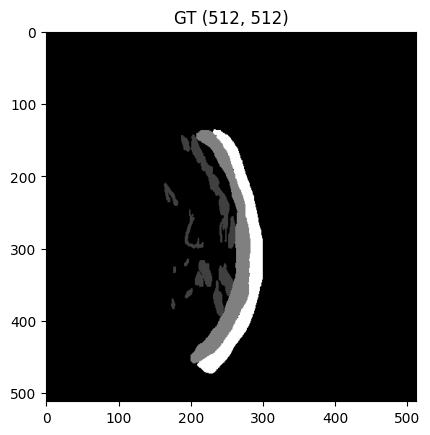

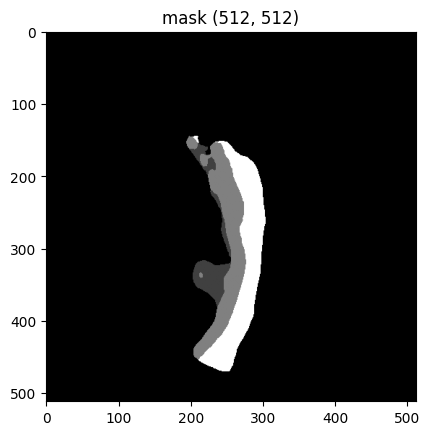

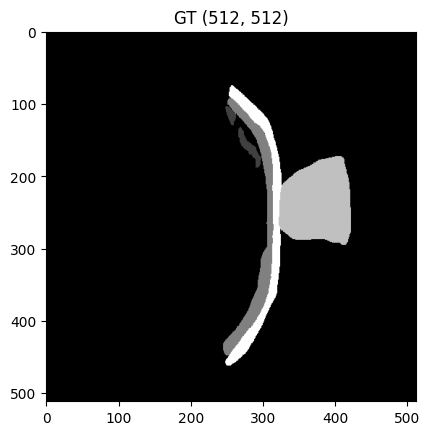

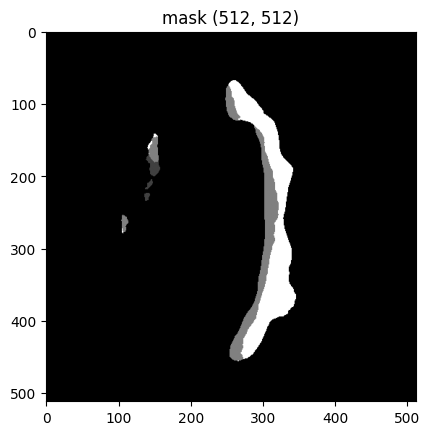

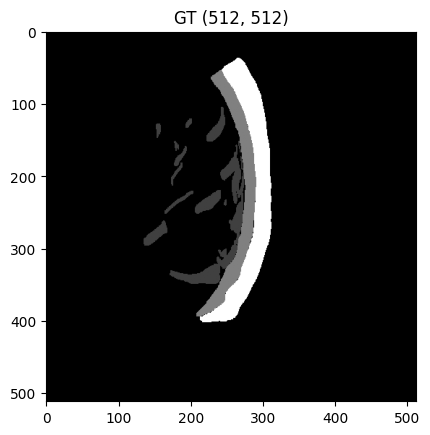

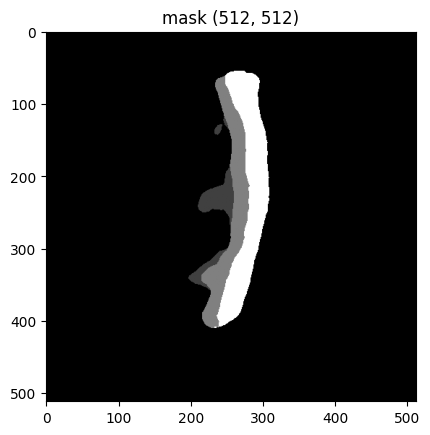

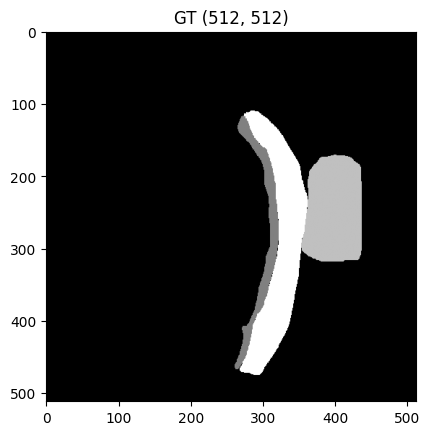

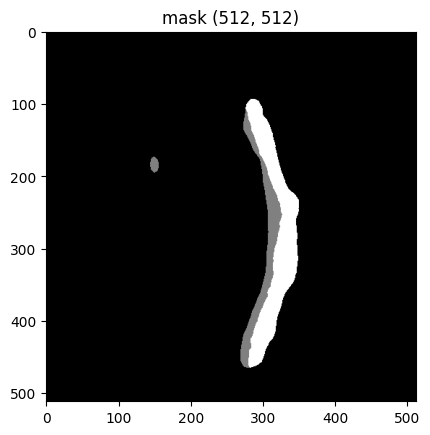

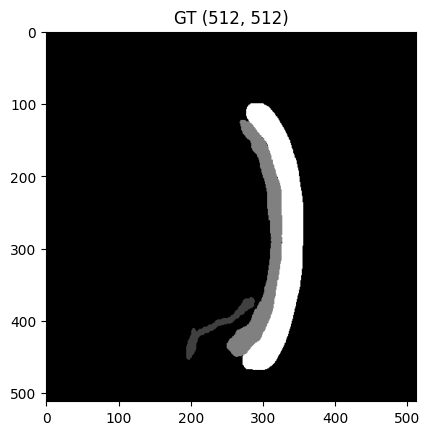

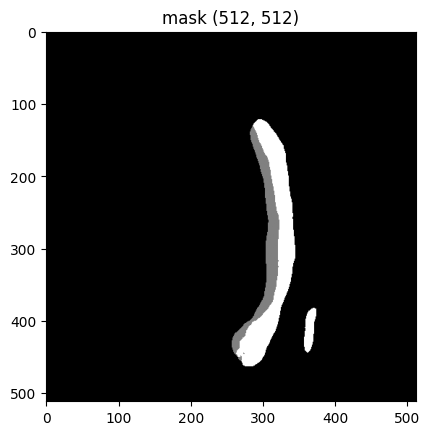

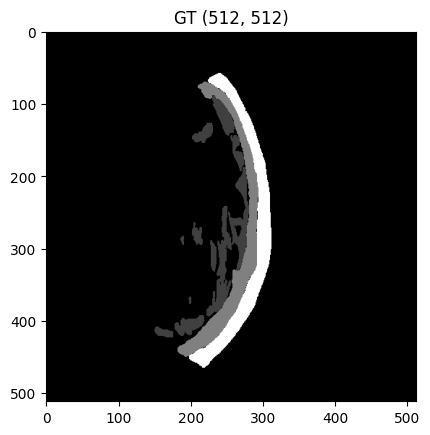

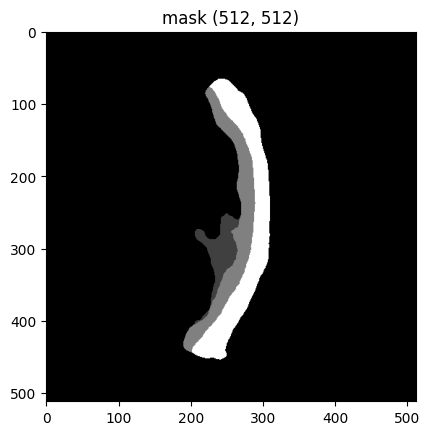

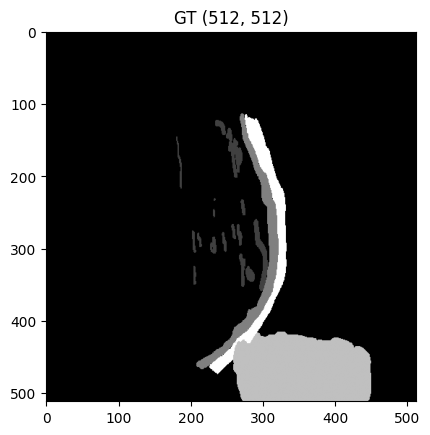

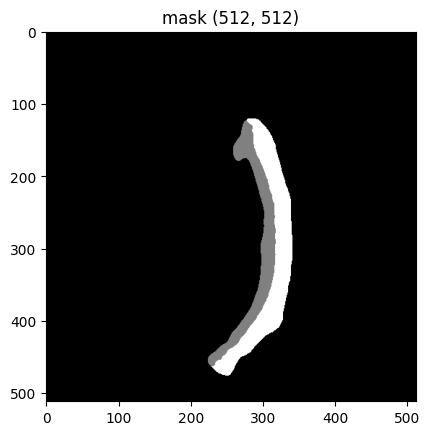

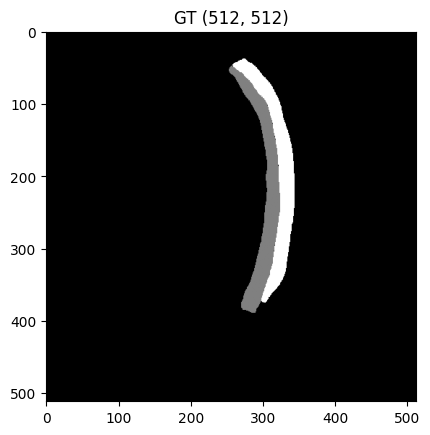

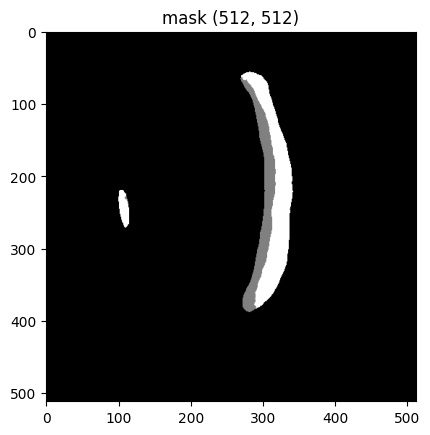

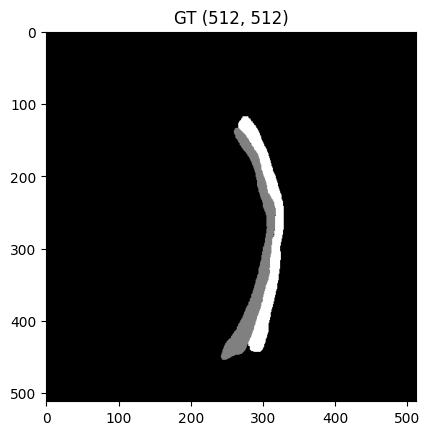

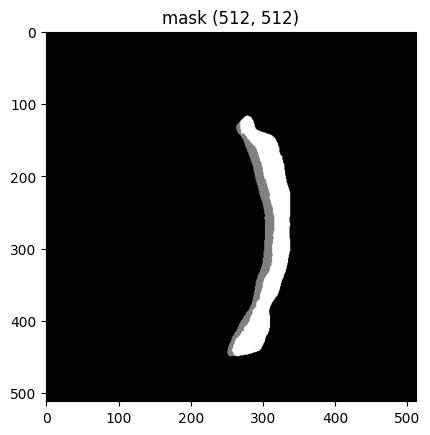

In [32]:
import cv2, numpy as np, glob, os
import matplotlib.pyplot as plt
root = "/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe/2025-11-26_07-17-54/outputs/best110_dice0.717"
vals = set()
for p in glob.glob(os.path.join(root + "/mask_pre", "*.png"))[:200]:
    print(p)


    gt = cv2.imread(p.replace("mask_pre", "mask_gt"), cv2.IMREAD_UNCHANGED)
    plt.figure()
    plt.title(f"GT {gt.shape}")
    plt.imshow(gt, cmap='gray'); plt.axis('on')

    m = cv2.imread(p, cv2.IMREAD_UNCHANGED)
    plt.figure()
    plt.title(f"mask {m.shape}")
    vals.update(np.unique(m).tolist())
    plt.imshow(m, cmap='gray'); plt.axis('on')
print("Pred unique labels:", sorted(vals))





### TEST Previews

In [22]:
import cv2, numpy as np, glob, os
import matplotlib.pyplot as plt

root = "/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_08-37-18/outputs/best_test_dice0.731"
vals = set()

for p in glob.glob(os.path.join(root, "mask_pre", "*.png"))[:200]:
    print(p)

    gt = cv2.imread(p.replace("mask_pre", "mask_gt"), cv2.IMREAD_UNCHANGED)
    m  = cv2.imread(p, cv2.IMREAD_UNCHANGED)

    # one figure, two subplots in a row
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.title(f"GT {gt.shape}")
    plt.imshow(gt, cmap='gray')
    plt.axis('on')

    plt.subplot(1, 2, 2)
    plt.title(f"Pred {m.shape}")
    plt.imshow(m, cmap='gray')
    plt.axis('on')

    plt.tight_layout()
    plt.show()

    vals.update(np.unique(m).tolist())

print("Pred unique labels:", sorted(vals))


Pred unique labels: []


/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient4__Subject_4.3.png


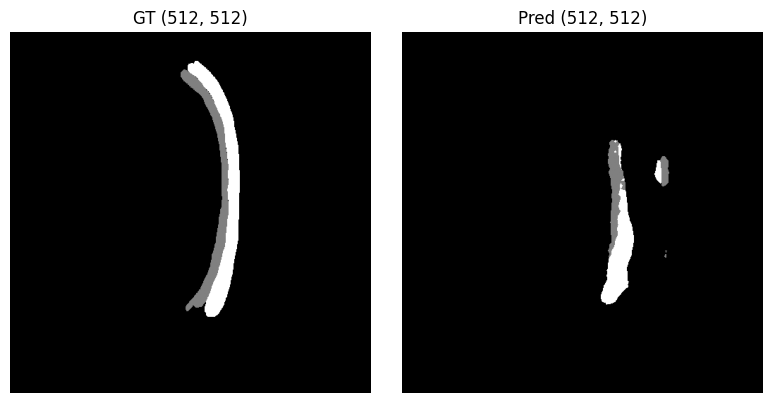

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient4__Subject_4.7.png


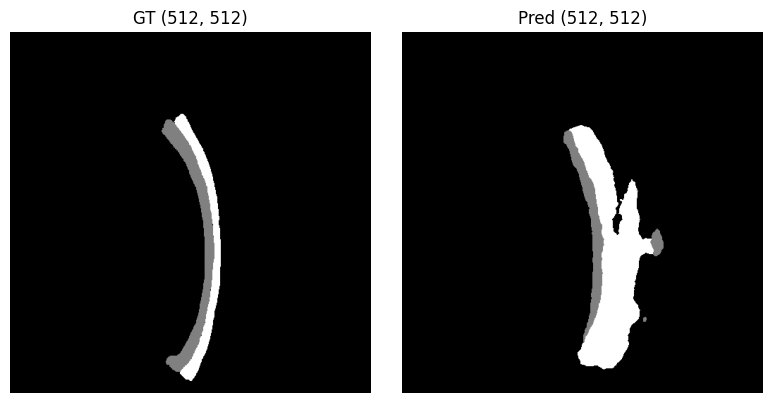

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient4__Subject_4.9.png


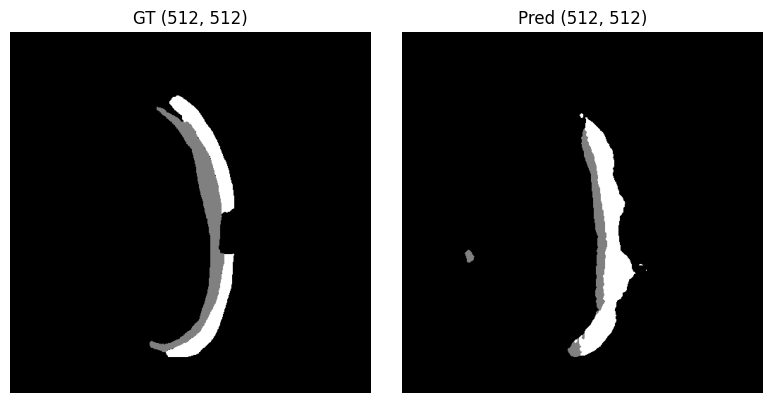

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient4__Subject_4.6.png


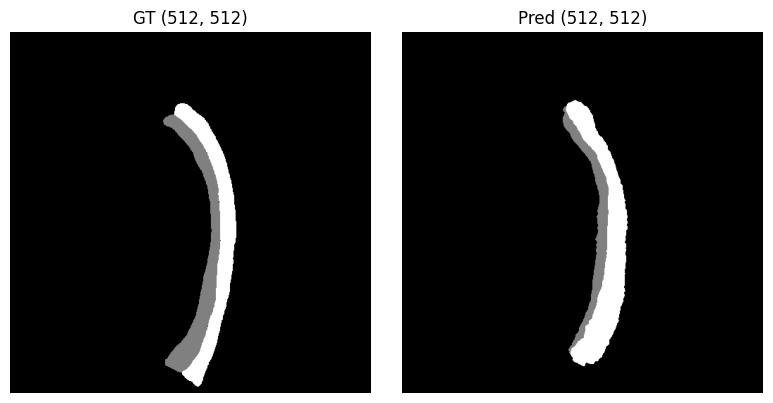

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient4__Subject_4.1.png


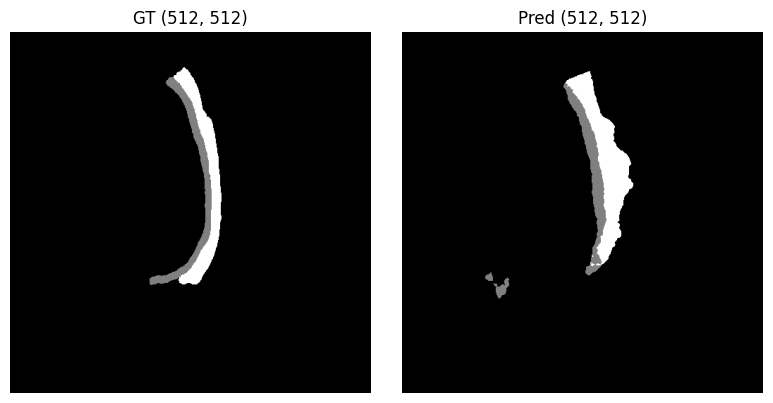

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient4__Subject_4.4.png


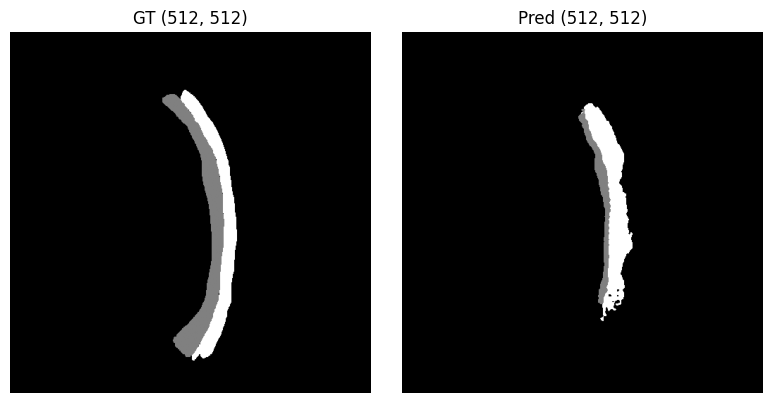

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient4__Subject_4.8.png


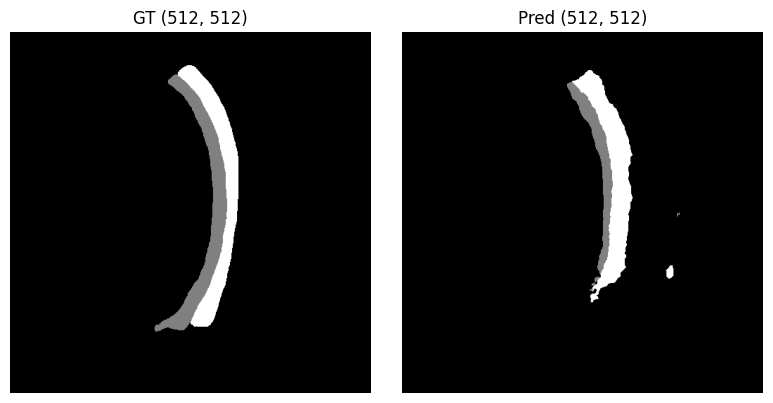

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient4__Subject_4.5.png


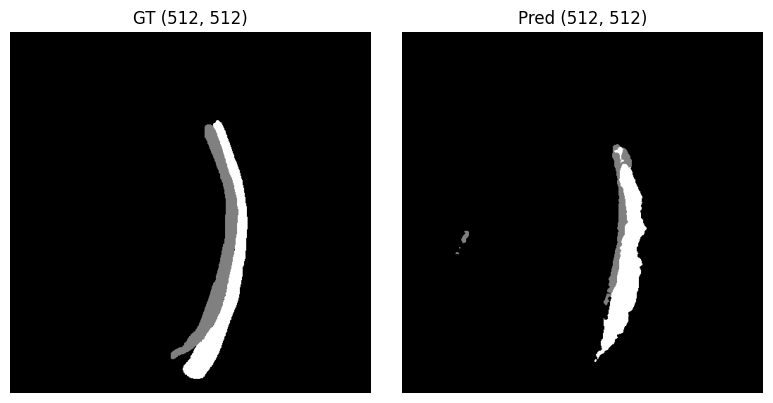

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient4__Subject_4.2.png


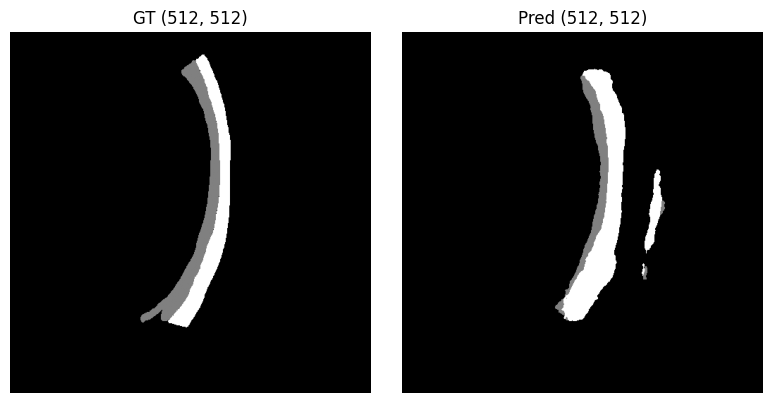

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient4__Subject_4.10.png


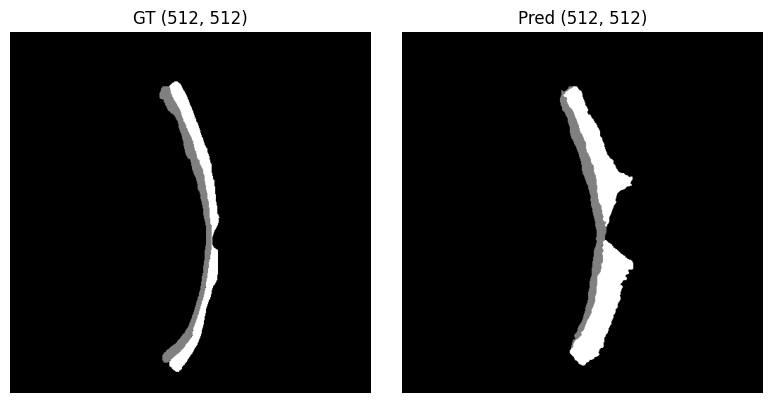

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient7__Subject_8.1.png


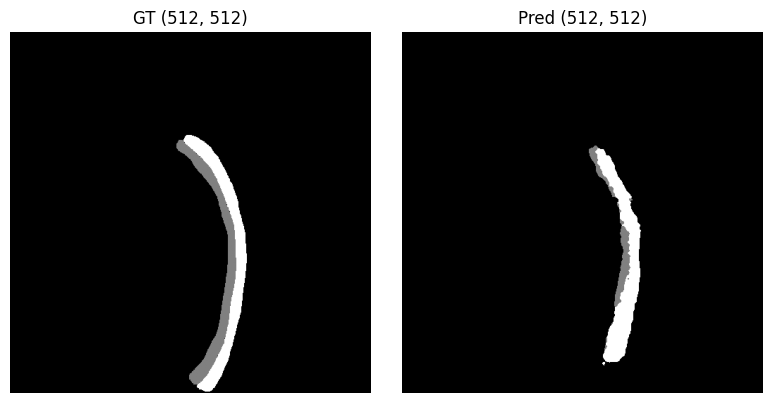

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient7__Subject_8.3.png


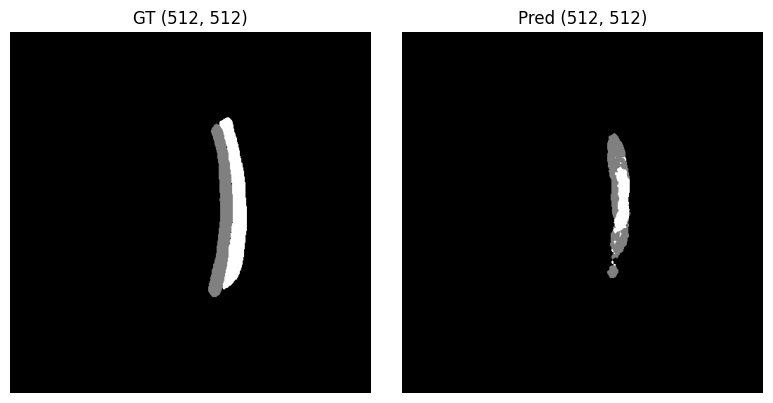

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient7__Subject_8.2.png


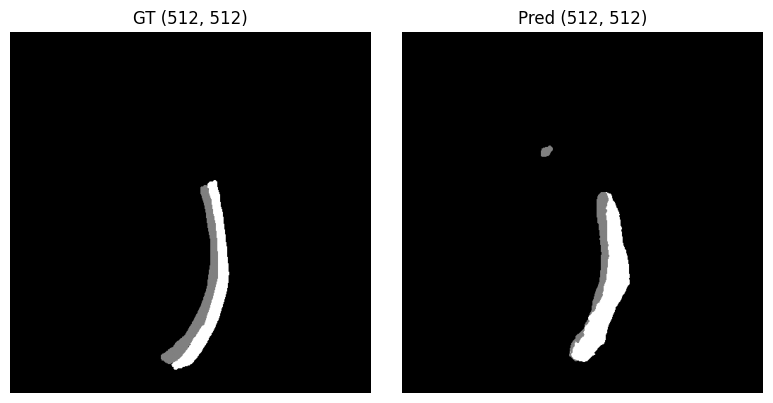

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient7__Subject_8.4.png


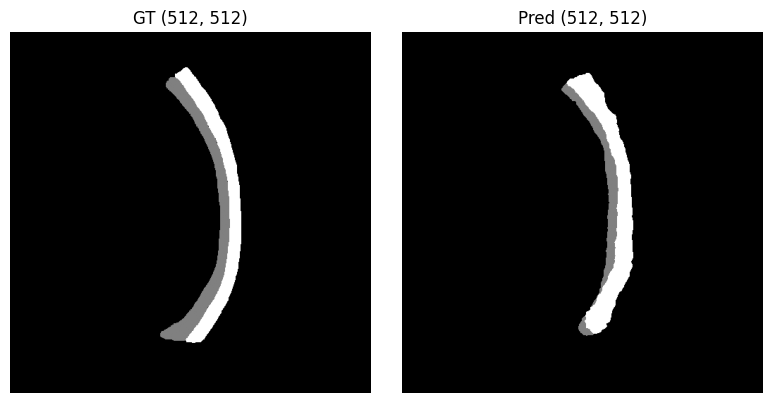

Pred unique labels: [0, 1, 2]

=== Per-class presence summary over folder ===
background      | GT pixels:   95.315%  Pred pixels: 95.481%  ||  GT images:   100.0%  Pred images: 100.0%
vitreous_humor  | GT pixels:    2.210%  Pred pixels:  1.277%  ||  GT images:   100.0%  Pred images: 100.0%
retina          | GT pixels:    2.475%  Pred pixels:  3.243%  ||  GT images:   100.0%  Pred images: 100.0%
optic_nerve     | GT pixels:    0.000%  Pred pixels:  0.000%  ||  GT images:     0.0%  Pred images:   0.0%
choroid         | GT pixels:    0.000%  Pred pixels:  0.000%  ||  GT images:     0.0%  Pred images:   0.0%


In [23]:
import cv2, numpy as np, glob, os
import matplotlib.pyplot as plt

root=        "/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731"

num_classes = 5  # 0=bg, 1=VH, 2=retina, 3=ON, 4=choroid
class_names = {
    0: "background",
    1: "vitreous_humor",
    2: "retina",
    3: "optic_nerve",
    4: "choroid",
}

vals = set()

# accumulators
gt_pixels      = np.zeros(num_classes, dtype=np.int64)
pred_pixels    = np.zeros(num_classes, dtype=np.int64)
gt_img_present = np.zeros(num_classes, dtype=np.int64)
pred_img_present = np.zeros(num_classes, dtype=np.int64)

total_pixels = 0
num_images   = 0

for p in glob.glob(os.path.join(root, "mask_pre", "*.png"))[:200]:
    print(p)

    gt = cv2.imread(p.replace("mask_pre", "mask_gt"), cv2.IMREAD_UNCHANGED)
    m  = cv2.imread(p, cv2.IMREAD_UNCHANGED)

    # sanity: ensure shapes match
    assert gt.shape == m.shape, f"Shape mismatch {gt.shape} vs {m.shape} for {p}"

    h, w = gt.shape[:2]
    total_pixels += h * w
    num_images   += 1

    # one figure, two subplots in a row (optional – keep or comment out if too many)
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.title(f"GT {gt.shape}")
    plt.imshow(gt, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Pred {m.shape}")
    plt.imshow(m, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    vals.update(np.unique(m).tolist())

    # --- accumulate per-class stats ---
    for c in range(num_classes):
        gt_mask   = (gt == c)
        pred_mask = (m  == c)

        gt_pixels[c]   += int(gt_mask.sum())
        pred_pixels[c] += int(pred_mask.sum())

        if gt_mask.any():
            gt_img_present[c] += 1
        if pred_mask.any():
            pred_img_present[c] += 1

print("Pred unique labels:", sorted(vals))

print("\n=== Per-class presence summary over folder ===")
for c in range(num_classes):
    name = class_names.get(c, f"class_{c}")
    if total_pixels > 0 and num_images > 0:
        gt_pix_pct   = 100.0 * gt_pixels[c]   / float(total_pixels)
        pred_pix_pct = 100.0 * pred_pixels[c] / float(total_pixels)

        gt_img_pct   = 100.0 * gt_img_present[c]   / float(num_images)
        pred_img_pct = 100.0 * pred_img_present[c] / float(num_images)
    else:
        gt_pix_pct = pred_pix_pct = gt_img_pct = pred_img_pct = float("nan")

    print(
        f"{name:15s} | "
        f"GT pixels:   {gt_pix_pct:6.3f}%  "
        f"Pred pixels: {pred_pix_pct:6.3f}%  ||  "
        f"GT images:   {gt_img_pct:5.1f}%  "
        f"Pred images: {pred_img_pct:5.1f}%"
    )

# PRED Previews

In [9]:
import cv2, numpy as np, glob, os
import matplotlib.pyplot as plt

# root = "/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe/2025-11-26_07-17-54/outputs/best110_dice0.717"
root=        "/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731"

num_classes = 5  # 0=bg, 1=VH, 2=retina, 3=ON, 4=choroid
class_names = {
    0: "background",
    # 1: "vitreous_humor",
    1: "retina",
    # 3: "optic_nerve",
    2: "choroid",
}

# Supervisely colors (RGB)
CLASS_COLORS = {
    0: (0, 0, 0),           # background (black)
    # 1: (0xBD, 0x10, 0xE0),  # VH          #BD10E0
    1: (0x07, 0xEC, 0x7B),  # retina      #07EC7B
    # 3: (0x01, 0x0A, 0xFE),  # ON          #010AFE
    2: (0xF8, 0xE7, 0x1C),  # choroid     #F8E71C
}

# --- toggle this flag ---
VH_ONLY = False   # set True to highlight only VH, False to show all classes

def colorize_mask(mask, vh_only=False):
    """
    mask: HxW int labels in [0..4]
    returns: HxW x 3 RGB uint8 image
    """
    if mask.ndim == 3:
        mask = mask[..., 0]

    h, w = mask.shape
    color_img = np.zeros((h, w, 3), dtype=np.uint8)

    if vh_only:
        # background stays black; only VH (1) gets colored
        c = 1
        color_img[mask == c] = CLASS_COLORS[c]
    else:
        for c, col in CLASS_COLORS.items():
            color_img[mask == c] = col

    return color_img

vals = set()

# accumulators
gt_pixels         = np.zeros(num_classes, dtype=np.int64)
pred_pixels       = np.zeros(num_classes, dtype=np.int64)
gt_img_present    = np.zeros(num_classes, dtype=np.int64)
pred_img_present  = np.zeros(num_classes, dtype=np.int64)

total_pixels = 0
num_images   = 0

for p in glob.glob(os.path.join(root, "mask_pre", "*.png"))[:200]:
    print(p)

    gt = cv2.imread(p.replace("mask_pre", "mask_gt"), cv2.IMREAD_UNCHANGED)
    m  = cv2.imread(p, cv2.IMREAD_UNCHANGED)

    # ensure single-channel label masks
    if gt.ndim == 3:
        gt = gt[..., 0]
    if m.ndim == 3:
        m = m[..., 0]

    assert gt.shape == m.shape, f"Shape mismatch {gt.shape} vs {m.shape} for {p}"

    h, w = gt.shape[:2]
    total_pixels += h * w
    num_images   += 1

    # --- visualization: color-coded masks ---
    gt_color = colorize_mask(gt, vh_only=VH_ONLY)
    pred_color = colorize_mask(m, vh_only=VH_ONLY)

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.title(f"GT {gt.shape}")
    plt.imshow(gt_color)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Pred {m.shape}")
    plt.imshow(pred_color)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    vals.update(np.unique(m).tolist())

    # --- accumulate per-class stats ---
    for c in range(num_classes):
        gt_mask   = (gt == c)
        pred_mask = (m  == c)

        gt_pixels[c]   += int(gt_mask.sum())
        pred_pixels[c] += int(pred_mask.sum())

        if gt_mask.any():
            gt_img_present[c] += 1
        if pred_mask.any():
            pred_img_present[c] += 1

print("Pred unique labels:", sorted(vals))

print("\n=== Per-class presence summary over folder ===")
for c in range(num_classes):
    name = class_names.get(c, f"class_{c}")
    if total_pixels > 0 and num_images > 0:
        gt_pix_pct   = 100.0 * gt_pixels[c]   / float(total_pixels)
        pred_pix_pct = 100.0 * pred_pixels[c] / float(total_pixels)

        gt_img_pct   = 100.0 * gt_img_present[c]   / float(num_images)
        pred_img_pct = 100.0 * pred_img_present[c] / float(num_images)
    else:
        gt_pix_pct = pred_pix_pct = gt_img_pct = pred_img_pct = float("nan")

    print(
        f"{name:15s} | "
        f"GT pixels:   {gt_pix_pct:6.3f}%  "
        f"Pred pixels: {pred_pix_pct:6.3f}%  ||  "
        f"GT images:   {gt_img_pct:5.1f}%  "
        f"Pred images: {pred_img_pct:5.1f}%"
    )

Pred unique labels: []

=== Per-class presence summary over folder ===
background      | GT pixels:      nan%  Pred pixels:    nan%  ||  GT images:     nan%  Pred images:   nan%
retina          | GT pixels:      nan%  Pred pixels:    nan%  ||  GT images:     nan%  Pred images:   nan%
choroid         | GT pixels:      nan%  Pred pixels:    nan%  ||  GT images:     nan%  Pred images:   nan%
class_3         | GT pixels:      nan%  Pred pixels:    nan%  ||  GT images:     nan%  Pred images:   nan%
class_4         | GT pixels:      nan%  Pred pixels:    nan%  ||  GT images:     nan%  Pred images:   nan%


# VAL PREVIEWS BY BEST TRAINING CKKPT

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient4__Subject_4.3.png


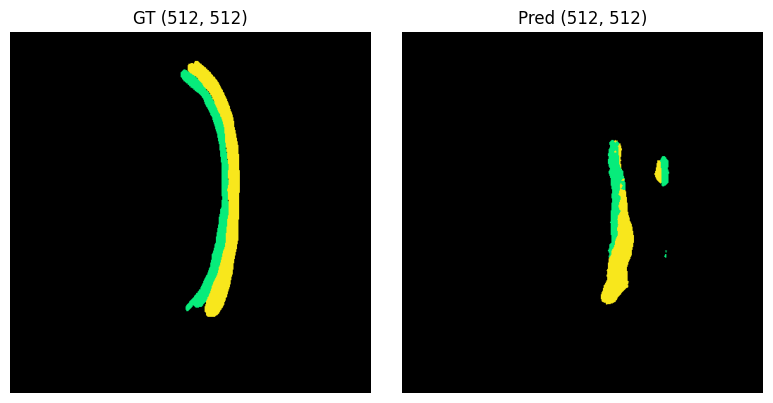

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient4__Subject_4.7.png


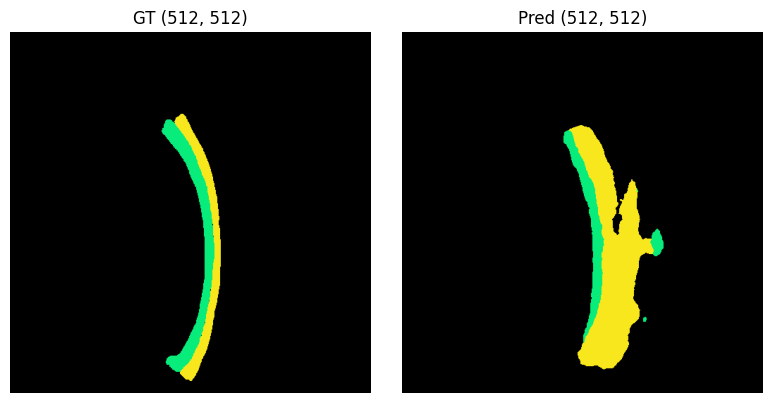

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient4__Subject_4.9.png


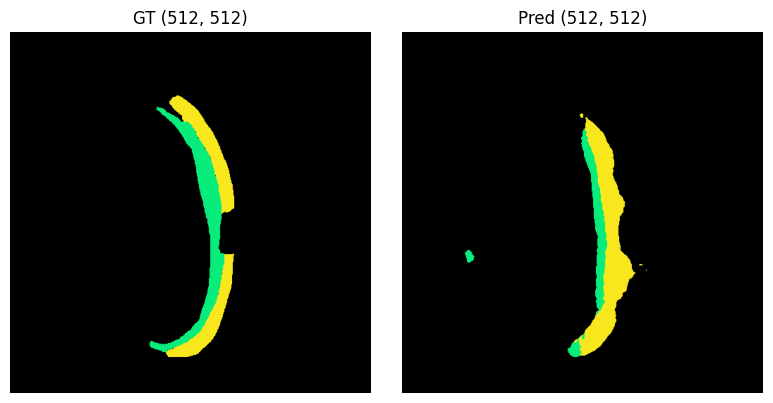

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient4__Subject_4.6.png


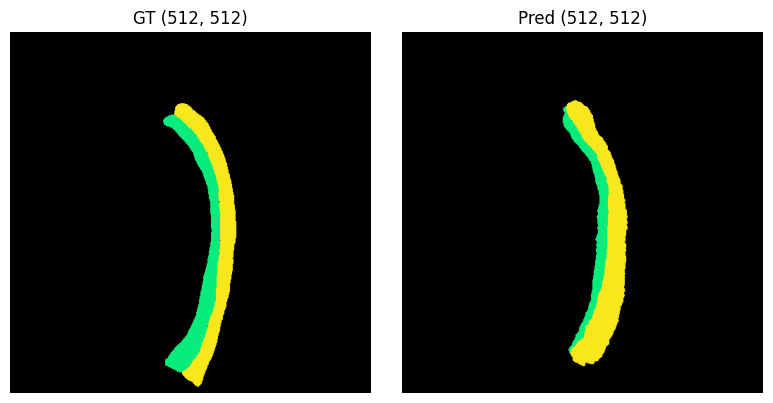

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient4__Subject_4.1.png


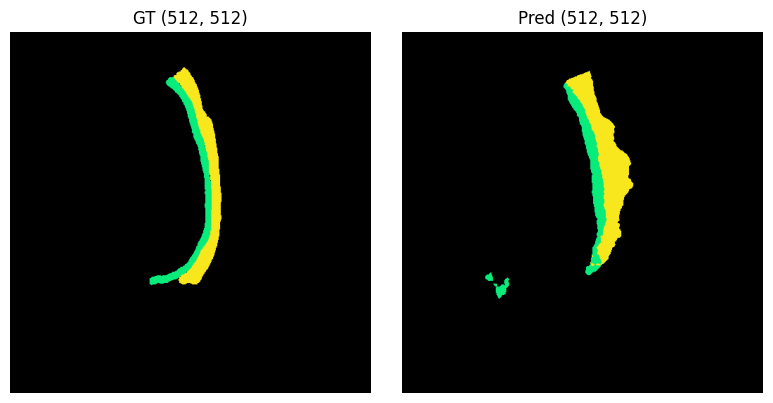

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient4__Subject_4.4.png


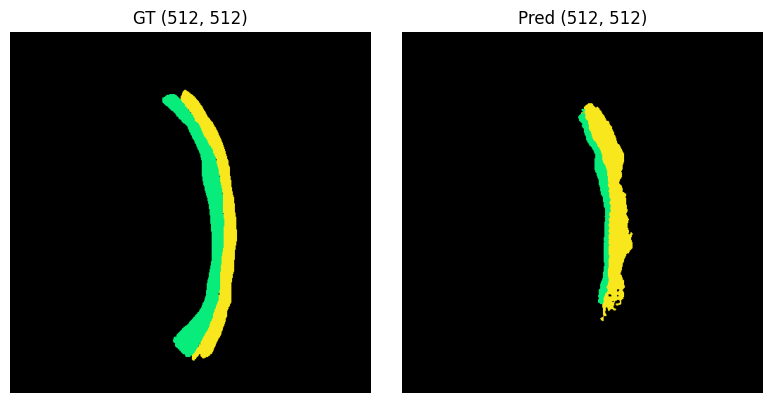

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient4__Subject_4.8.png


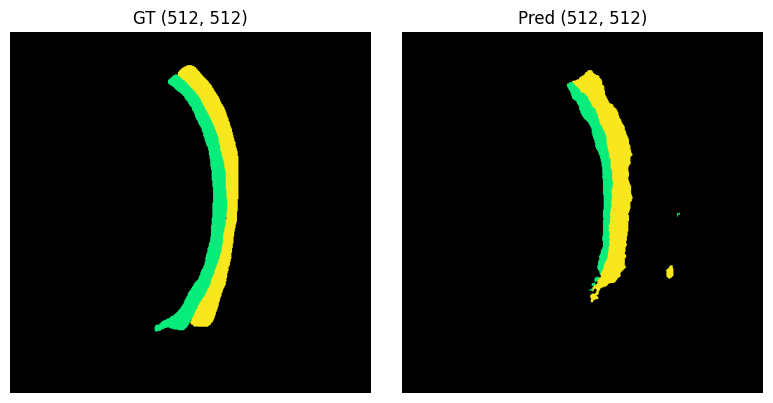

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient4__Subject_4.5.png


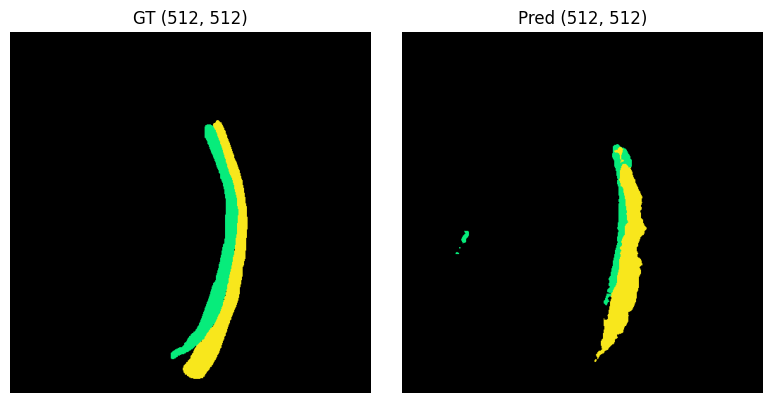

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient4__Subject_4.2.png


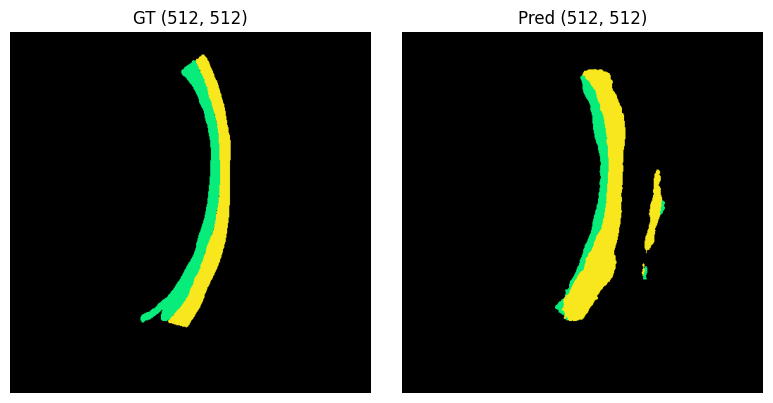

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient4__Subject_4.10.png


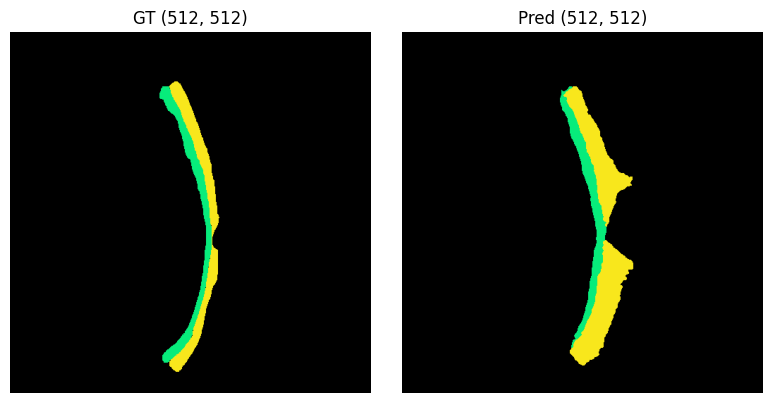

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient7__Subject_8.1.png


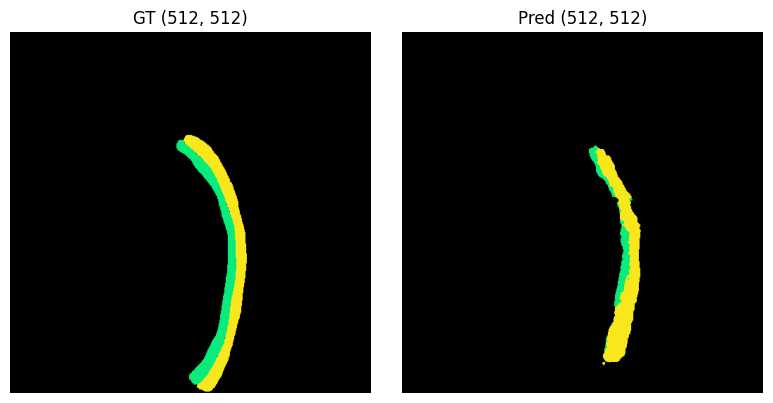

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient7__Subject_8.3.png


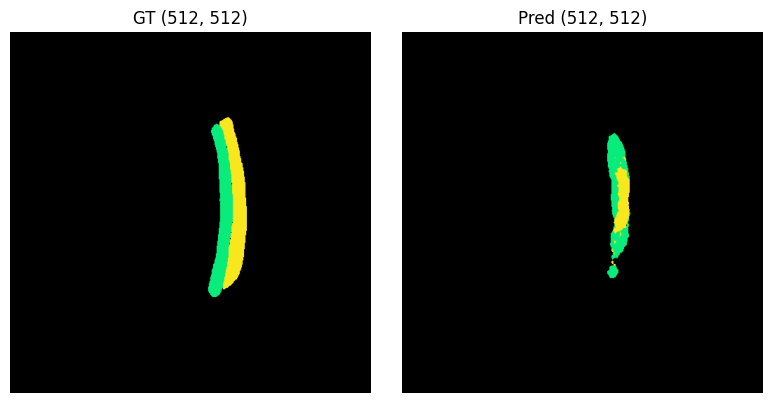

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient7__Subject_8.2.png


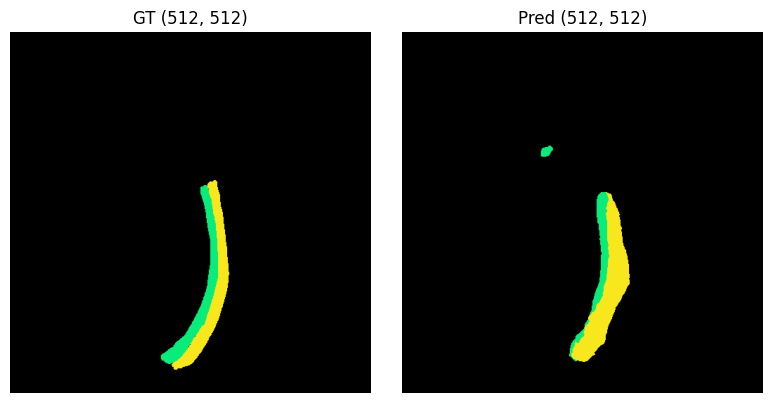

/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731/mask_pre/Patient7__Subject_8.4.png


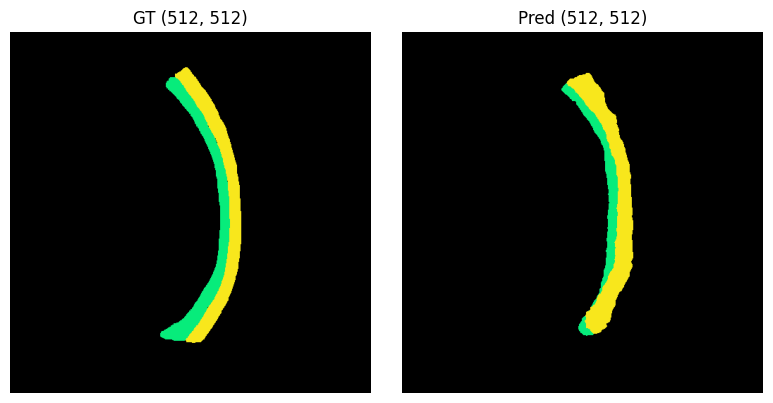

Pred unique labels: [0, 1, 2]

=== Per-class presence summary over folder ===
background      | GT pixels:   95.315%  Pred pixels: 95.481%  ||  GT images:   100.0%  Pred images: 100.0%
retina          | GT pixels:    2.210%  Pred pixels:  1.277%  ||  GT images:   100.0%  Pred images: 100.0%
choroid         | GT pixels:    2.475%  Pred pixels:  3.243%  ||  GT images:   100.0%  Pred images: 100.0%
class_3         | GT pixels:    0.000%  Pred pixels:  0.000%  ||  GT images:     0.0%  Pred images:   0.0%
class_4         | GT pixels:    0.000%  Pred pixels:  0.000%  ||  GT images:     0.0%  Pred images:   0.0%


In [24]:
import cv2, numpy as np, glob, os
import matplotlib.pyplot as plt

# root = "/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe/2025-11-26_07-17-54/outputs/best110_dice0.717"
root=        "/content/drive/MyDrive/USFM/USFM_repo/logs/finetune/Seg/retina_usg/Upernet/upernet_probe_test/2025-11-28_00-37-18/outputs/best_test_dice0.731"

num_classes = 5  # 0=bg, 1=VH, 2=retina, 3=ON, 4=choroid
class_names = {
    0: "background",
    # 1: "vitreous_humor",
    1: "retina",
    # 3: "optic_nerve",
    2: "choroid",
}

# Supervisely colors (RGB)
CLASS_COLORS = {
    0: (0, 0, 0),           # background (black)
    # 1: (0xBD, 0x10, 0xE0),  # VH          #BD10E0
    1: (0x07, 0xEC, 0x7B),  # retina      #07EC7B
    # 3: (0x01, 0x0A, 0xFE),  # ON          #010AFE
    2: (0xF8, 0xE7, 0x1C),  # choroid     #F8E71C
}

# --- toggle this flag ---
VH_ONLY = False   # set True to highlight only VH, False to show all classes

def colorize_mask(mask, vh_only=False):
    """
    mask: HxW int labels in [0..4]
    returns: HxW x 3 RGB uint8 image
    """
    if mask.ndim == 3:
        mask = mask[..., 0]

    h, w = mask.shape
    color_img = np.zeros((h, w, 3), dtype=np.uint8)

    if vh_only:
        # background stays black; only VH (1) gets colored
        c = 1
        color_img[mask == c] = CLASS_COLORS[c]
    else:
        for c, col in CLASS_COLORS.items():
            color_img[mask == c] = col

    return color_img

vals = set()

# accumulators
gt_pixels         = np.zeros(num_classes, dtype=np.int64)
pred_pixels       = np.zeros(num_classes, dtype=np.int64)
gt_img_present    = np.zeros(num_classes, dtype=np.int64)
pred_img_present  = np.zeros(num_classes, dtype=np.int64)

total_pixels = 0
num_images   = 0

for p in glob.glob(os.path.join(root, "mask_pre", "*.png"))[:200]:
    print(p)

    gt = cv2.imread(p.replace("mask_pre", "mask_gt"), cv2.IMREAD_UNCHANGED)
    m  = cv2.imread(p, cv2.IMREAD_UNCHANGED)

    # ensure single-channel label masks
    if gt.ndim == 3:
        gt = gt[..., 0]
    if m.ndim == 3:
        m = m[..., 0]

    assert gt.shape == m.shape, f"Shape mismatch {gt.shape} vs {m.shape} for {p}"

    h, w = gt.shape[:2]
    total_pixels += h * w
    num_images   += 1

    # --- visualization: color-coded masks ---
    gt_color = colorize_mask(gt, vh_only=VH_ONLY)
    pred_color = colorize_mask(m, vh_only=VH_ONLY)

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.title(f"GT {gt.shape}")
    plt.imshow(gt_color)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Pred {m.shape}")
    plt.imshow(pred_color)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    vals.update(np.unique(m).tolist())

    # --- accumulate per-class stats ---
    for c in range(num_classes):
        gt_mask   = (gt == c)
        pred_mask = (m  == c)

        gt_pixels[c]   += int(gt_mask.sum())
        pred_pixels[c] += int(pred_mask.sum())

        if gt_mask.any():
            gt_img_present[c] += 1
        if pred_mask.any():
            pred_img_present[c] += 1

print("Pred unique labels:", sorted(vals))

print("\n=== Per-class presence summary over folder ===")
for c in range(num_classes):
    name = class_names.get(c, f"class_{c}")
    if total_pixels > 0 and num_images > 0:
        gt_pix_pct   = 100.0 * gt_pixels[c]   / float(total_pixels)
        pred_pix_pct = 100.0 * pred_pixels[c] / float(total_pixels)

        gt_img_pct   = 100.0 * gt_img_present[c]   / float(num_images)
        pred_img_pct = 100.0 * pred_img_present[c] / float(num_images)
    else:
        gt_pix_pct = pred_pix_pct = gt_img_pct = pred_img_pct = float("nan")

    print(
        f"{name:15s} | "
        f"GT pixels:   {gt_pix_pct:6.3f}%  "
        f"Pred pixels: {pred_pix_pct:6.3f}%  ||  "
        f"GT images:   {gt_img_pct:5.1f}%  "
        f"Pred images: {pred_img_pct:5.1f}%"
    )